In [1]:
%pylab inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
set_printoptions(linewidth=300, threshold=200000, suppress=True, precision = 8)


Populating the interactive namespace from numpy and matplotlib


In [2]:
figsize(16,9)
def rf1h(dx, N, p):
    e, No = p
    dN = e * No * (N > 0)
    return -dN * dx

def rf1r(dx, N, p):
    e = p[0]
    dN = - e * N
    return dN * dx


def rf2h(dx, N, p):
    a, Ht, No = p
    dN = (a * No) / (1 + a * Ht * No) * (N > 0)
    #print (p, dN, -dN * dx, dx)
    return -dN * dx

def rf2r(dx, N, p):
    a, Ht, No = p
    dN = (a * N) / (1 + a * Ht * N)
    return -dN * dx

def rf2rp(dx, N, p):
    a, Ht, No = p
    dN = (N/No) * (a * N) / (1 + a * Ht * N)
    return -dN * dx

def rf3h(dx, N, p):
    a, Ht, No = p
    N2 = No ** 2
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    return -dN * dx

def rf3r(dx, N, p):
    a, Ht, No = p
    N2 = N ** 2
    dN = (a * N2) / (1 + a * Ht * N2)
    return -dN * dx

def rfgh(dx, N, p):
    a, Ht, k, No = p
    N2 = No ** k
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    return -dN * dx

def rfgr(dx, N, p):
    a, Ht, k, No = p
    N2 = N ** k
    dN = (a * N2) / (1 + a * Ht * N2)
    return -dN * dx


def rfl(dx, sv, p):
    """
    Functional response with learning
    la = learning in a
    lH = learning in handling time
    Mnt = minimum handling time
    ha = host depletion
    No = N initial
    sv = state variables
    """
    N, a, Ht = sv
    la, lH, Mnt, hd, No = p[:5]
    #print(la, lH, N, a, Ht)
    if hd: N2 = N
    else:  N2 = No
    
    dN = (a * N2) / (1 + a * Ht * N2) * (N > 0)
    da = la * (1 - a) * dN
    dH = lH * (Ht - Mnt) * dN
    return array([-dN, da, -dH]) * dx


def rk4(f, h, y, p):
    dx = h
    k1 = f(dx, y, p)
    k2 = f(dx, y + k1 / 2, p)
    k3 = f(dx, y + k2 / 2, p)
    k4 = f(dx, y + k3, p)
    return y + (k1 + 2 * k2 + 2 * k3 + k4) / 6


def plot_funcion(f, p, nombre = '', grafica = "integral", sv = 1, tmax = 10, ax = False):
    import crf_dinamica as rf
    if len(p) == 7:
        fraccion = 1024
    else:
        fraccion = 128
    y = zeros((tmax * fraccion + 1, sv))
    x = linspace(0, tmax, tmax * fraccion + 1)
    
    y[0] = p[-sv:]
    if len(p) == 7:
        y = rf.rfl(array(p, dtype = float64), tmax)
    else:
        for i in range(1, y.shape[0]):
            y[i] = rk4(f, x[1] - x[0], y[i-1], p)
        y[:,0] = y[0,0] - y[:,0]
    if grafica == "integral":
        ax.plot(x, y[:,0], label = nombre)
    elif grafica == "derivada":
        ax.plot(x[1:], fraccion * (y[1:,0] - y[:-1,0]), label = nombre)
    return x, y

def plot_rfn(f, p, nombre = '', grafica = "integral", sv = 1, tmax = 1, Nmax = 100, ax = False):
    
    x = linspace(0.5, Nmax, Nmax * 2)
    y = zeros_like(x)
    for i in range(x.shape[0]):
        p[-sv] = x[i]
        xx, N = plot_funcion(f, p, grafica = '', sv = sv, tmax = tmax, ax = ax)
        y[i] = N[-1, 0]
    if grafica == "integral":
        ax.plot(x, y, label = nombre)
    elif grafica == "derivada":
        ax.plot(x[:-1], 2 * (y[1:] - y[:-1]), label = nombre)
    elif grafica == "derivada2":
        dy = 2 * (y[1:] - y[:-1])
        d2 = dy[1:] - dy[:-1]
        #print(dy.max(), dy.min(), d2.max(), d2.min())
        ax.plot(x[1:-1], (dy[1:] - dy[:-1]), label = nombre)
    elif grafica == 'd20':
        dy =  y[1:] -  y[:-1]
        d2 = dy[1:] - dy[:-1]
        d2s = array(where(sign(d2[1:]) != sign(d2[:-1]))) * (x[1] - x[0])
        if d2s.size == 0:
            d2s = array([Nmax + 1])
        #print(" %3d %3d %3d %8.4f %8.4f %8.4f"%(len(y), len(dy), len(d2), d2s.min(), d2.max(), d2.min()), end = ' ')
        #sys.stdout.flush()
        return d2s.min(), d2.max(), d2.min()
    return x,y

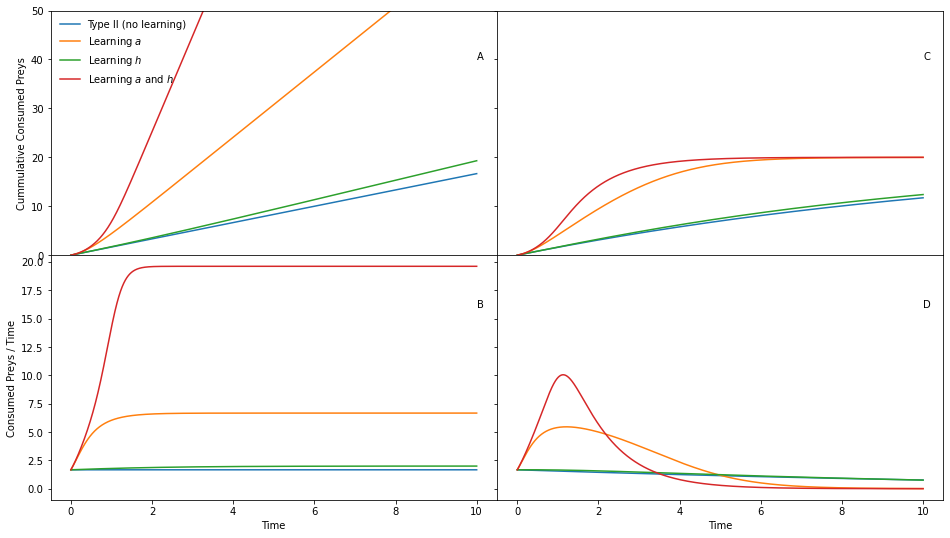

0.38461538461538464 [19.99797589  0.99777198  0.00124508]


In [3]:
figsize(16,9)
lr = 0.3
hm = 0.001
N = 20
a0 = 0.1

fig, ((ax1, ax3), (ax2, ax4)) = plt.subplots(2, 2, sharex=True, sharey = 'row', gridspec_kw={'hspace': 0, 'wspace': 0})
x, yh = plot_funcion(rfl,   [0.0, 0.0, 0.00, 0, N, a0, 0.1], "Type II (no learning)", sv = 3, ax = ax1)
x, yh = plot_funcion(rfl,   [lr, 0.0, 0.00, 0, N, a0, 0.1], "Learning $a$", sv = 3, ax = ax1)
x, yh = plot_funcion(rfl,   [0.0, lr, hm, 0, N, a0, 0.1], "Learning $h$", sv = 3, ax = ax1)
x, yh = plot_funcion(rfl,   [lr, lr, hm, 0, N, a0, 0.1], "Learning $a$ and $h$", sv = 3, ax = ax1)

ax1.set_ylabel("Cummulative Consumed Preys")
ax1.set_ylim(0,50)

x, yh = plot_funcion(rfl,   [0.0, 0.0, 0.00, 0, N, a0, 0.1], "Hollings type II (no learning)", sv = 3, ax = ax2, grafica = "derivada")
x, yh = plot_funcion(rfl,   [lr, 0.0, 0.00, 0, N, a0, 0.1], "Hollings type II (learning $a$)", sv = 3, ax = ax2, grafica = "derivada")
x, yh = plot_funcion(rfl,   [0.0, lr, hm, 0, N, a0, 0.1], "Hollings type II (learning $h$)", sv = 3, ax = ax2, grafica = "derivada")
x, yh = plot_funcion(rfl,   [lr, lr, hm, 0, N, a0, 0.1], "Hollings type II (learning $a$ and $h$)", sv = 3, ax = ax2, grafica = "derivada")
ax1.legend(frameon = False)

ax2.set_ylabel("Consumed Preys / Time")

x, yh = plot_funcion(rfl,   [0.0, 0.0, 0.00, 1, N, a0, 0.1], "Rogers type II (no learning)", sv = 3, ax = ax3)
x, yh = plot_funcion(rfl,   [lr, 0.0, 0.00, 1, N, a0, 0.1], "Rogers type II (learning $a$)", sv = 3, ax = ax3)
x, yh = plot_funcion(rfl,   [0.0, lr, hm, 1, N, a0, 0.1], "Rogers type II (learning $h$)", sv = 3, ax = ax3)
x, yh = plot_funcion(rfl,   [lr, lr, hm, 1, N, a0, 0.1], "Rogers type II (learning $a$ and $h$)", sv = 3, ax = ax3)
ax2.set_xlabel("Time")


x, yh = plot_funcion(rfl,   [0.0, 0.0, 0.00, 1, N, a0, 0.1], "Rogers type II (no learning)", sv = 3, ax = ax4, grafica = "derivada")
x, yh = plot_funcion(rfl,   [lr, 0.0, 0.00, 1, N, a0, 0.1], "Rogers type II (learning $a$)", sv = 3, ax = ax4, grafica = "derivada")
x, yh = plot_funcion(rfl,   [0.0, lr, hm, 1, N, a0, 0.1], "Rogers type II (learning $h$)", sv = 3, ax = ax4, grafica = "derivada")
x, yh = plot_funcion(rfl,   [lr, lr, hm, 1, N, a0, 0.1], "Rogers type II (learning $a$ and $h$)", sv = 3, ax = ax4, grafica = "derivada")
#ax4.set_ylim(0,25)
#ax4.legend(frameon = False)
ax4.set_xlabel("Time")

ax1.text(10,40,"A")
ax2.text(10,16,"B")
ax3.text(10,40,"C")
ax4.text(10,16,"D")

show()

print((a0 * 4) / (1 + a0 * 0.1 * 4), yh[-1])

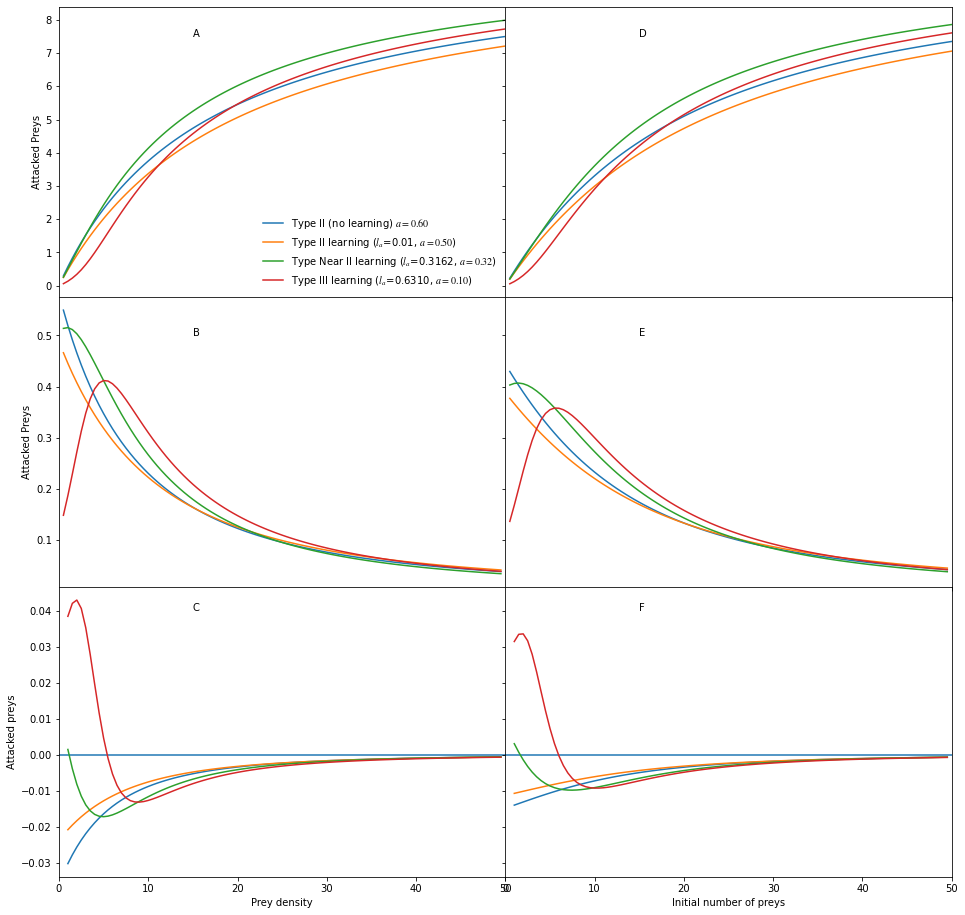

In [4]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'

figsize(16,16)
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex=True, sharey = 'row', gridspec_kw={'hspace': 0, 'wspace': 0})

la  = power(10, -2.0), 0.5
la1 = power(10, -0.5), 0.5
la2 = power(10, -0.2), 0.1

x,sdh = plot_rfn(rfl, [0.0,    0.0, 0, 0, 200.0, 0.6,    0.1], "Type II (no learning) $a=%4.2f$"%0.6,    sv = 3, Nmax = 50, ax = ax1)
x,sdh = plot_rfn(rfl, [la[0],  0.0, 0, 0, 200.0, la[1],  0.1], "Type II learning ($l_a$=%4.2f, $a=%4.2f$)"%(la[0],la[1]),  sv = 3, Nmax = 50, ax = ax1)
x,sdh = plot_rfn(rfl, [la1[0], 0.0, 0, 0, 200.0, la1[1], 0.1], "Type Near II learning ($l_a$=%6.4f, $a=%4.2f$)"%(la1[0],la1[0]), sv = 3, Nmax = 50, ax = ax1)
x,sdh = plot_rfn(rfl, [la2[0], 0.0, 0, 0, 200.0, la2[1], 0.1], "Type III learning ($l_a$=%6.4f, $a=%4.2f$)"%(la2[0],la2[1]), sv = 3, Nmax = 50, ax = ax1)
ax1.legend(frameon = False)
ax1.set_ylabel("Attacked Preys")
x,sdh = plot_rfn(rfl, [0.0,    0.0, 0, 1, 200.0, 0.6,    0.1], "Type II Holling (no learning) $a=%4.2f$"%0.6,    sv = 3, Nmax = 50, ax = ax4)
x,sdh = plot_rfn(rfl, [la[0],  0.0, 0, 1, 200.0, la[1],  0.1], "Type II learning ($l_a$=%4.2f, $a=%4.2f$)"%(la[0],la[1]),  sv = 3, Nmax = 50, ax = ax4)
x,sdh = plot_rfn(rfl, [la1[0], 0.0, 0, 1, 200.0, la1[1], 0.1], "Type Near II learning ($l_a$=%6.4f, $a=%4.2f$)"%(la1[0],la1[0]), sv = 3, Nmax = 50, ax = ax4)
x,sdh = plot_rfn(rfl, [la2[0], 0.0, 0, 1, 200.0, la2[1], 0.1], "Type III learning ($l_a$=%6.4f, $a=%4.2f$)"%(la2[0],la2[1]), sv = 3, Nmax = 50, ax = ax4)


x,sdh = plot_rfn(rfl, [0.0,    0.0, 0.0, 0, 200.0, 0.6,    0.1], "Type II Holling (no learning)",    grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
x,sdh = plot_rfn(rfl, [la[0],  0.0, 0.0, 0, 200.0, la[1],  0.1], "Type II learning ($l_a$=%4.2f, $a=%4.2f$)"%(la[0],la[1]),  grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
x,sdh = plot_rfn(rfl, [la1[0], 0.0, 0.0, 0, 200.0, la1[1], 0.1], "Type Near II learning ($l_a$=%6.4f, $a=%4.2f$)"%(la1[0],la1[0]), grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
x,sdh = plot_rfn(rfl, [la2[0], 0.0, 0.0, 0, 200.0, la2[1], 0.1], "Type III learning ($l_a$=%6.4f)"%la2[0], grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
ax2.set_ylabel("Attacked Preys")
x,sdh = plot_rfn(rfl, [0.0,    0.0, 0.0, 1, 200.0, 0.6,    0.1], "Type II Holling (no learning)",    grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)
x,sdh = plot_rfn(rfl, [la[0],  0.0, 0.0, 1, 200.0, la[1],  0.1], "Type II learning ($l_a$=%4.2f, $a=%4.2f$)"%(la[0],la[1]),  grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)
x,sdh = plot_rfn(rfl, [la1[0], 0.0, 0.0, 1, 200.0, la1[1], 0.1], "Type Near II learning ($l_a$=%6.4f, $a=%4.2f$)"%(la1[0],la1[0]), grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)
x,sdh = plot_rfn(rfl, [la2[0], 0.0, 0.0, 1, 200.0, la2[1], 0.1], "Type III learning ($l_a$=%6.4f)"%la2[0], grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)

x,sdh = plot_rfn(rfl, [0.0,    0.0, 0.0, 0, 200.0, 0.6,    0.1], "Type II holling (no learning)",         grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)
x,sdh = plot_rfn(rfl, [la[0],   0.0, 0.0, 0, 200.0, la[1], 0.1], "Type II learning ($l_a$=%4.2f, $a=%4.2f$)"%(la[0],la[1]),  grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)
x,sdh = plot_rfn(rfl, [la1[0], 0.0, 0.0, 0, 200.0, la1[1], 0.1], "Type Near II learning ($l_a$=%6.4f, $a=%4.2f$)"%(la1[0],la1[0]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)
x,sdh = plot_rfn(rfl, [la2[0], 0.0, 0.0, 0, 200.0, la2[1], 0.1], "Type III ($l_a$=%6.4f, $a=%4.2f$)"%(la2[0],la2[1]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)


x,sdh = plot_rfn(rfl, [0.0,    0.0, 0.0, 1, 200.0, 0.6,    0.1], "Type II holling (no learning)",         grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)
x,sdh = plot_rfn(rfl, [la[0],  0.0, 0.0, 1, 200.0, la[1],  0.1], "Type II learning ($l_a$=%4.2f, $a=%4.2f$)"%(la[0],la[1]),  grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)
x,sdh = plot_rfn(rfl, [la1[0], 0.0, 0.0, 1, 200.0, la1[1], 0.1], "Type Near II learning ($l_a$=%6.4f, $a=%4.2f$)"%(la1[0],la1[0]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)
x,sdh = plot_rfn(rfl, [la2[0], 0.0, 0.0, 1, 200.0, la2[1], 0.1], "Type III ($l_a$=%6.4f, $a=%4.2f$)"%(la2[0],la2[1]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)

ax3.set_xlabel("Prey density")
ax6.set_xlabel("Initial number of preys")
ax3.set_ylabel("Attacked preys")
ax3.hlines(0,0,50)
ax6.hlines(0,0,50)
ax3.set_xlim(0,50)

ax1.text(15,7.5,"A")
ax4.text(15,7.5,"D")

ax2.text(15,0.5,"B")
ax5.text(15,0.5,"E")

ax3.text(15,0.04,"C")
ax6.text(15,0.04,"F")


show()

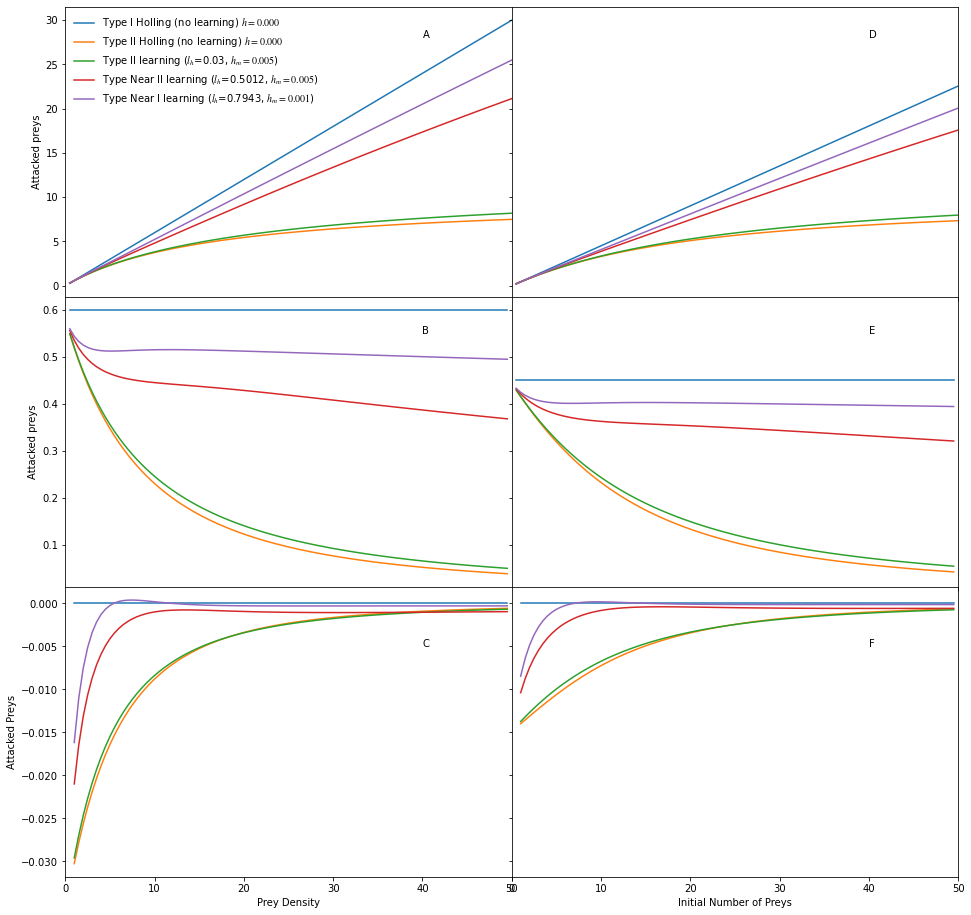

In [5]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'

figsize(16,16)
fig, ((ax1,ax4),(ax2,ax5),(ax3,ax6)) = plt.subplots(3, 2, sharex=True, sharey = 'row', gridspec_kw={'hspace': 0, 'wspace': 0})

lh  = power(10, -1.5), 0.005
lh1 = power(10, -0.3), 0.005
lh2 = power(10, -0.1), 0.001

x,sdh = plot_rfn(rf1h, [0.6, 200.0], "Type I Holling (no learning) $h=%5.3f$"%0.0,    sv = 1, Nmax = 50, ax = ax1)
x,sdh = plot_rfn(rfl, [0.0, 0.0,    0,      0, 200.0, 0.6,    0.1], "Type II Holling (no learning) $h=%5.3f$"%0.0,    sv = 3, Nmax = 50, ax = ax1)
x,sdh = plot_rfn(rfl, [0.0, lh[0],  lh[1],  0, 200.0, 0.6,    0.1], "Type II learning ($l_h$=%4.2f, $h_m=%5.3f$)"%(lh[0],lh[1]),  sv = 3, Nmax = 50, ax = ax1)
x,sdh = plot_rfn(rfl, [0.0, lh1[0], lh1[1], 0, 200.0, 0.6,    0.1], "Type Near II learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh1[0],lh1[1]), sv = 3, Nmax = 50, ax = ax1)
x,sdh = plot_rfn(rfl, [0.0, lh2[0], lh2[1], 0, 200.0, 0.6,    0.1], "Type Near I learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh2[0],lh2[1]), sv = 3, Nmax = 50, ax = ax1)
ax1.legend(frameon = False)
ax1.set_ylabel("Attacked preys")

x,sdh = plot_rfn(rf1r, [0.6, 200.0], "Type I Holling (no learning) $h=%5.3f$"%0.0,    sv = 1, Nmax = 50, ax = ax4)
x,sdh = plot_rfn(rfl, [0.0, 0.0,    0,      1, 200.0, 0.6,    0.1], "Type II Holling (no learning) $h=%5.3f$"%0.0,    sv = 3, Nmax = 50, ax = ax4)
x,sdh = plot_rfn(rfl, [0.0, lh[0],  lh[1],  1, 200.0, 0.6,    0.1], "Type II learning ($l_h$=%4.2f, $h_m=%5.3f$)"%(lh[0],lh[1]),  sv = 3, Nmax = 50, ax = ax4)
x,sdh = plot_rfn(rfl, [0.0, lh1[0], lh1[1], 1, 200.0, 0.6,    0.1], "Type Near II learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh1[0],lh1[1]), sv = 3, Nmax = 50, ax = ax4)
x,sdh = plot_rfn(rfl, [0.0, lh2[0], lh2[1], 1, 200.0, 0.6,    0.1], "Type Near I learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh2[0],lh2[1]), sv = 3, Nmax = 50, ax = ax4)

x,sdh = plot_rfn(rf1h, [0.6, 200.0], "Type I Holling (no learning) $h=%5.3f$"%0.0,   grafica = "derivada", sv = 1, Nmax = 50, ax = ax2)
x,sdh = plot_rfn(rfl, [0.0,    0.0,  0.0,    0, 200.0, 0.6,  0.1], "Type II Holling (no learning) $h=%5.3f$"%0.0,    grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
x,sdh = plot_rfn(rfl, [0.0,  lh[0],  lh[1],  0, 200.0, 0.6,  0.1], "Type II learning ($l_h$=%4.2f, $h_m=%5.3f$)"%(lh[0],lh[1]),  grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
x,sdh = plot_rfn(rfl, [0.0,  lh1[0], lh1[1], 0, 200.0, 0.6,  0.1], "Type Near II learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh1[0],lh1[1]), grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
x,sdh = plot_rfn(rfl, [0.0,  lh2[0], lh2[1], 0, 200.0, 0.6,  0.1], "Type Near I ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh2[0],lh2[1]), grafica = "derivada", sv = 3, Nmax = 50, ax = ax2)
ax2.set_ylabel("Attacked preys")

x,sdh = plot_rfn(rf1r, [0.6, 200.0], "Type I Holling (no learning) $h=%5.3f$"%0.0,   grafica = "derivada", sv = 1, Nmax = 50, ax = ax5)
x,sdh = plot_rfn(rfl, [0.0,    0.0,  0.0,    1, 200.0, 0.6,  0.1], "Type II Holling (no learning) $h=%5.3f$"%0.0,    grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)
x,sdh = plot_rfn(rfl, [0.0,  lh[0],  lh[1],  1, 200.0, 0.6,  0.1], "Type II learning ($l_h$=%4.2f, $h_m=%5.3f$)"%(lh[0],lh[1]),  grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)
x,sdh = plot_rfn(rfl, [0.0,  lh1[0], lh1[1], 1, 200.0, 0.6,  0.1], "Type Near II learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh1[0],lh1[1]), grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)
x,sdh = plot_rfn(rfl, [0.0,  lh2[0], lh2[1], 1, 200.0, 0.6,  0.1], "Type Near I ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh2[0],lh2[1]), grafica = "derivada", sv = 3, Nmax = 50, ax = ax5)
ax2.set_ylabel("Attacked preys")

x,sdh = plot_rfn(rf1h, [0.6, 200.0], "Type I Holling (no learning) $h=%4.2f$"%0.0,   grafica = "derivada2", sv = 1, Nmax = 50, ax = ax3)
x,sdh = plot_rfn(rfl, [0.0,    0.0,     0.0, 0,  200.0,  0.6,   0.1], "Type II holling (no learning) $h=%5.3f$"%0.0,         grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)
x,sdh = plot_rfn(rfl, [0.0,  lh[0],   lh[1], 0, 200.0, 0.6,   0.1], "Type II learning ($l_h$=%4.2f, $h_m=%5.3f$)"%(lh[0],lh[1]),  grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)
x,sdh = plot_rfn(rfl, [0.0,  lh1[0], lh1[1], 0, 200.0,  0.6,   0.1], "Type Near II learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh1[0],lh1[1]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)
x,sdh = plot_rfn(rfl, [0.0,  lh2[0], lh2[1], 0, 200.0,  0.6,   0.1], "Type Near I ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh2[0],lh2[1]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax3)

x,sdh = plot_rfn(rf1r, [0.6, 200.0], "Type I Holling (no learning) $h=%4.2f$"%0.0,   grafica = "derivada2", sv = 1, Nmax = 50, ax = ax6)
x,sdh = plot_rfn(rfl, [0.0,    0.0,     0.0, 1,  200.0,  0.6,   0.1], "Type II holling (no learning) $h=%5.3f$"%0.0,         grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)
x,sdh = plot_rfn(rfl, [0.0,  lh[0],   lh[1], 1, 200.0, 0.6,   0.1], "Type II learning ($l_h$=%4.2f, $h_m=%5.3f$)"%(lh[0],lh[1]),  grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)
x,sdh = plot_rfn(rfl, [0.0,  lh1[0], lh1[1], 1, 200.0,  0.6,   0.1], "Type Near II learning ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh1[0],lh1[1]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)
x,sdh = plot_rfn(rfl, [0.0,  lh2[0], lh2[1], 1, 200.0,  0.6,   0.1], "Type Near I ($l_h$=%6.4f, $h_m=%5.3f$)"%(lh2[0],lh2[1]), grafica = "derivada2", sv = 3, Nmax = 50, ax = ax6)

#ax3.legend(Typeameon = False)
ax3.set_xlabel("Prey Density")
ax6.set_xlabel("Initial Number of Preys")
ax3.set_ylabel("Attacked Preys")
ax3.set_xlim(0,50)

ax1.text(40,28,"A")
ax4.text(40,28,"D")

ax2.text(40,0.55,"B")
ax5.text(40,0.55,"E")

ax3.text(40,-0.005,"C")
ax6.text(40,-0.005,"F")
show()